In [1]:
from datetime import datetime, timedelta
import pickle
import copy

from package.query import *
from package.plot import *
from package.data_mgt import *
from package.seriealize import *
from package.dic_mgt import *
from package.data import *

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34588, 34752, 34701, 34865, 34813, 34976, 34924', '34593, 34544, 34709, 34660, 34825, 34776, 34941', '34963, 35158, 35008, 35273, 35589, 35784, 35634', '34783, 34682, 35130, 35326, 35519, 35789, 36053', '34738, 33847, 34395, 35346, 34998, 35644, 36384', '34539, 34589, 34804, 34854, 34909, 34918, 35050', '34426, 33995, 34131, 34558, 34594, 34741, 34542', '34610, 34824, 34813, 34927, 34955, 35038, 35095', '34753, 34812, 34929, 35101, 35245, 35322, 35493', '34698, 34785, 34424, 34230, 34031, 33858, 33925']
serialized list :  [[34588, 34752, 34701, 34865, 34813, 34976, 34924], [34593, 34544, 34709, 34660, 34825, 34776, 34941], [34963, 35158, 35008, 35273, 35589, 35784, 35634], [34783, 34682, 35130, 35326, 35519, 35789, 36053], [34738, 33847, 34395, 35346, 34998, 35644, 36384], [34539, 34589, 34804, 34854, 34909, 34918, 35050], [34426, 33995, 34131, 34558, 34594, 34741, 34542], [34610, 34824, 34813, 34927, 34955, 35038,

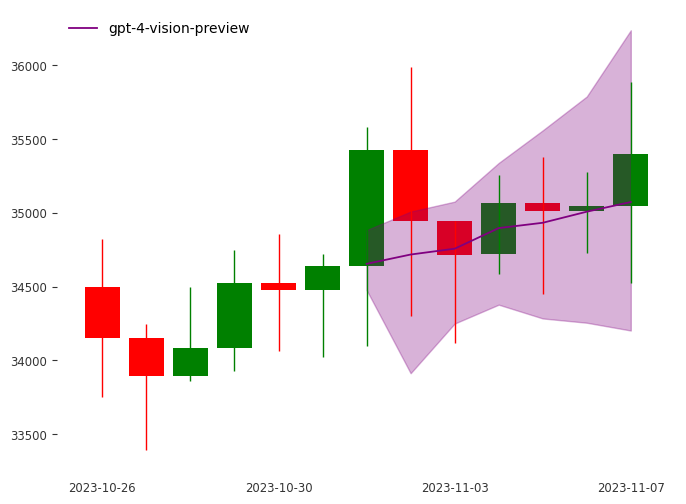

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34696, 34751, 34806, 34861, 34916, 34971, 35026', '34831, 34916, 35281, 35161, 35422, 35753, 35608', '34701, 34843, 34792, 34924, 34871, 35004, 34949', '34439, 33949, 34481, 35210, 35922, 36811, 37256', '34436, 34060, 34087, 34319, 34261, 34385, 34208', '34798, 34865, 34957, 35104, 35219, 35308, 35393', '34614, 34749, 34668, 34835, 34722, 34921, 34774', '34588, 34420, 34714, 34935, 34984, 35213, 35160', '34739, 35122, 35207, 35133, 35138, 35244, 35399', '34769, 34944, 35172, 35339, 35494, 35619, 35798']
serialized list :  [[34696, 34751, 34806, 34861, 34916, 34971, 35026], [34831, 34916, 35281, 35161, 35422, 35753, 35608], [34701, 34843, 34792, 34924, 34871, 35004, 34949], [34439, 33949, 34481, 35210, 35922, 36811, 37256], [34436, 34060, 34087, 34319, 34261, 34385, 34208], [34798, 34865, 34957, 35104, 35219, 35308, 35393], [34614, 34749, 34668, 34835, 34722, 34921, 34774], 

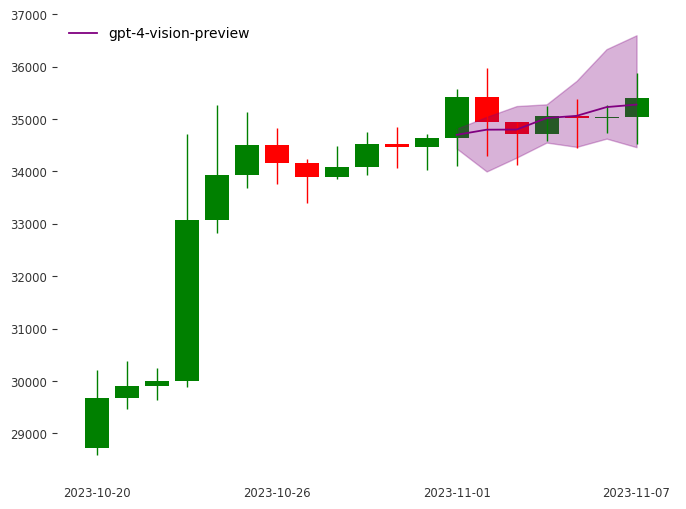

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34672, 34746, 34847, 34973, 35092, 35189, 35265', '34771, 34947, 35211, 35785, 36321, 36898, 37325', '34404, 34462, 33816, 33189, 33312, 32601, 32759', '35104, 35551, 36018, 36499, 36995, 37406, 37832', '34748, 35076, 35243, 34846, 34757, 34872, 34913', '34845, 35072, 35231, 35311, 35179, 35046, 35123', '34791, 34957, 35066, 35205, 35316, 35406, 35473', '34557, 34563, 34622, 34653, 34771, 34801, 34923', '34670, 34915, 35066, 35446, 35497, 35538, 35753', '34587, 34678, 34714, 34839, 35157, 36102, 36316']
serialized list :  [[34672, 34746, 34847, 34973, 35092, 35189, 35265], [34771, 34947, 35211, 35785, 36321, 36898, 37325], [34404, 34462, 33816, 33189, 33312, 32601, 32759], [35104, 35551, 36018, 36499, 36995, 37406, 37832], [34748, 35076, 35243, 34846, 34757, 34872, 34913], [34845, 35072, 352

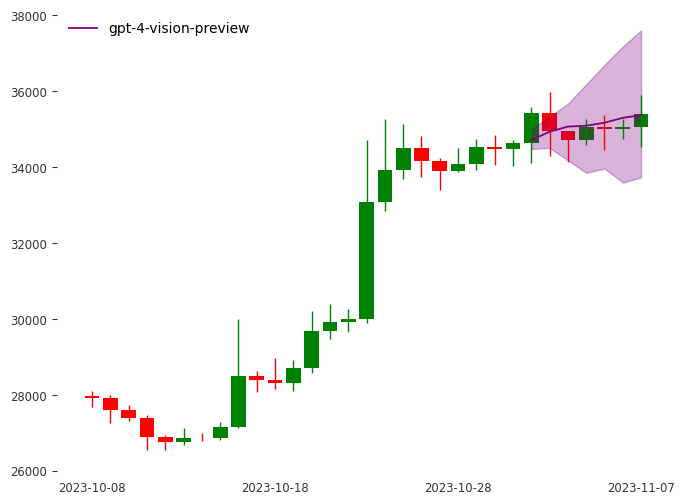

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34446, 34239, 34350, 34407, 34187, 33980, 33891', '34702, 34791, 34833, 34904, 34988, 35015, 35042', '34690, 34739, 34788, 34837, 34886, 34935, 34984', '34582, 34523, 34666, 34758, 34889, 35126, 35293', '34740, 34784, 34825, 34869, 34910, 34955, 34996', '34782, 34814, 34983, 35305, 35763, 35984, 36005', '34676, 34704, 34719, 34725, 34724, 34718, 34709', '34649, 34672, 34673, 34692, 34708, 34725, 34741', '34487, 34363, 34276, 34391, 34333, 34245, 34217', '34711, 34942, 35138, 35317, 35561, 35870, 36025']
serialized list :  [[34446, 34239, 34350, 34407, 34187, 33980, 33891], [34702, 34791, 34833, 34904, 34988, 35015, 35042], [34

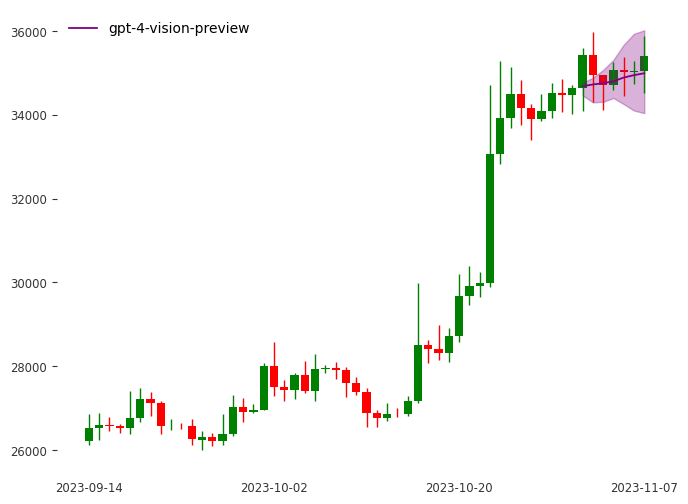

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34628, 34583, 34547, 34321, 34020, 33842, 33730', '34621, 34757, 34900, 34704, 34939, 35492, 35380', '34723, 34836, 35014, 35123, 35268, 35422, 35589', '34567, 34534, 34403, 34838, 34591, 34559, 34854', '34618, 34595, 34572, 34549, 34526, 34503, 34480', '34595, 34718, 34658, 34684, 34722, 34600, 3

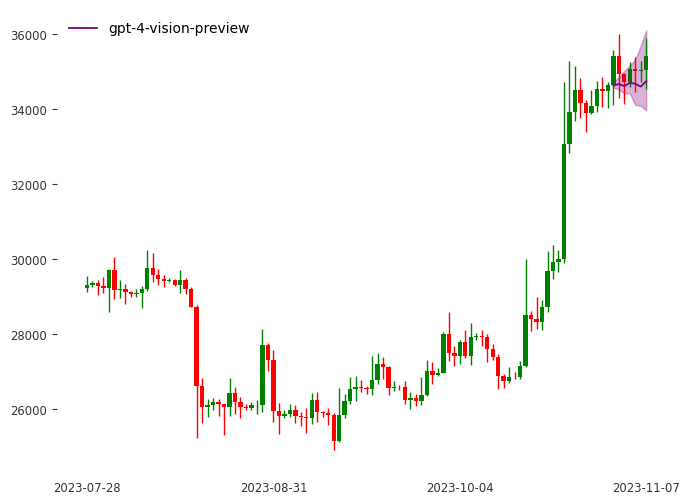

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

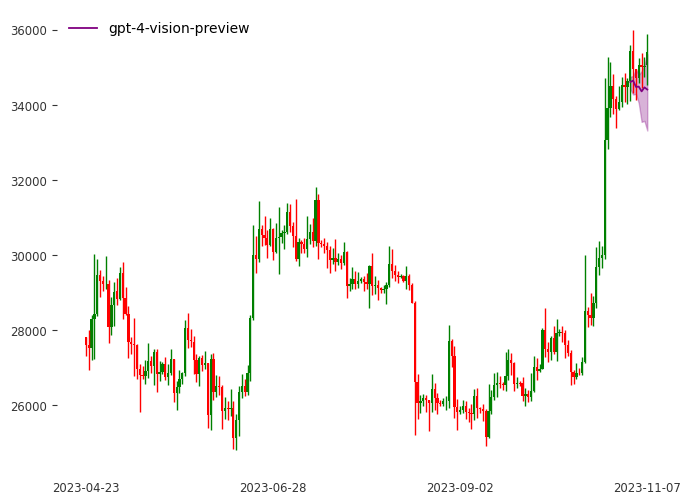

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_naive_bitcoin.pkl
pickle/dic_error_naive_bitcoin_median.pkl


In [2]:
data = bitcoin_data( mode = "naive")
make_prediction(data)

In [2]:
all_naive_dic = make_dic_MAE_MSE(path1="pickle/dic_error_naive_bitcoin.pkl", path2 = "pickle/dic_error_naive_bitcoin_median.pkl")

dic_error :
{'input_length': {6: {'Mae': [[834.1311324621565, 189.4386935766306, 16.120457388336945, 198.0552485164735, 199.94646482999815, 69.90327358125796, 475.7765866253467], [829.1311324621565, 397.4386935766306, 8.120457388336945, 403.0552485164735, 187.94646482999815, 269.90327358125796, 458.7765866253467], [459.13113246215653, 216.5613064233694, 290.87954261166306, 209.9447514835265, 576.0535351700019, 738.096726418742, 234.22341337465332], [639.1311324621565, 259.4386935766306, 412.87954261166306, 262.9447514835265, 506.05353517000185, 743.096726418742, 653.2234133746533], [684.1311324621565, 1094.4386935766306, 322.12045738833694, 282.9447514835265, 14.946464829998149, 598.096726418742, 984.2234133746533], [883.1311324621565, 352.4386935766306, 86.87954261166306, 209.0552485164735, 103.94646482999815, 127.90327358125796, 349.7765866253467], [996.1311324621565, 946.4386935766306, 586.120457388337, 505.0552485164735, 418.94646482999815, 304.90327358125796, 857.7765866253467], [

In [3]:
display_tab(all_naive_dic)

Global MAE/MSE
Mean error with 3 days forecasting
  input_length      Mae     Mse
--------------  -------  ------
             6  457.127  310183
            12  453.423  313812
            24  465.761  325616
            48  416.253  265717
            96  417.273  253778
           192  481.447  310561
Mean error with 5 days forecasting
  input_length      Mae     Mse
--------------  -------  ------
             6  401.434  251687
            12  382.334  243482
            24  527.681  508062
            48  393.632  233247
            96  405.866  235167
           192  550.191  413805
Mean error with 7 days forecasting
  input_length      Mae     Mse
--------------  -------  ------
             6  432.601  296219
            12  414.914  322480
            24  646.106  858619
            48  440.398  300808
            96  479.932  335494
           192  665.157  634290
##############################
Median MAE/MSE
Median error with 3 days forecasting
  input_length      Mae     M

Input str :  -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['104, 169, 23, 86, 142, 207, 61', '112, 172, -86, -33, 209, 253, -159', '111, -172, 236, -64, 344, -260, 452', '-179, -30, 150, 105, -120, -5, 225', '112, 131, -131, 27, 107, 9, 104', '64, 147, 1, 63, 72, 155, -13', '115, 215, 372, 584, 851, 1173, 1552', '112, 244, 243, 495, 496, 992, 993', '76, 165, 60, 246, 141, 348, 257', '111, -35, 139, -311, 484, -764, 1249']
int list return
[[104, 169, 23, 86, 142, 207, 61], [112, 172, -86, -33, 209, 253, -159], [111, -172, 236, -64, 344, -260, 452], [-179, -30, 150, 105, -120, -5, 225], [112, 131, -131, 27, 107, 9, 104], [64, 147, 1, 63, 72, 155, -13], [115, 215, 372, 584, 851, 1173, 1552], [112, 244, 243, 495, 496, 992, 993], [76, 165, 60, 246, 141, 348, 257], [111, -35, 139, -311, 484, -764, 1249]]
serialized list :  [[35001.00242843393, 35592.51936947446, 35674.38216402425, 35981.18185063486, 36492.11463291387, 37247.50140581519, 37474.71116439066], [35028.71501943032, 35631.2089177645

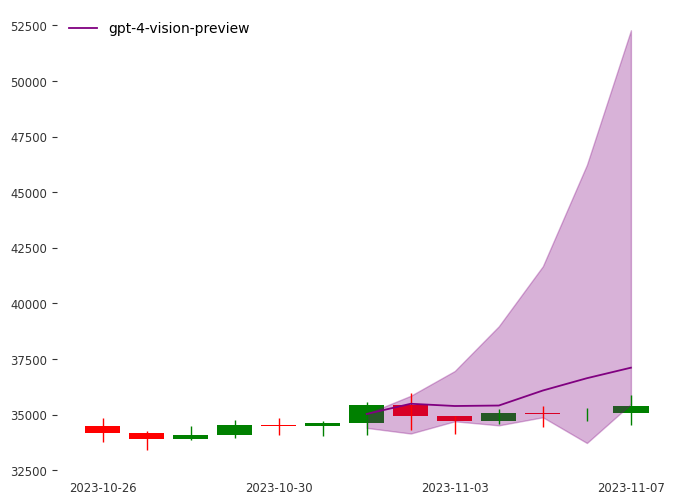

Input str :  333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['315, 271, 487, -243, -219, 153, 228', '-2, -20, 19, 34, -1, 17, -11', '2, -39, 12, -2, 22, 0, 10', '327, 326, -51, -78, -159, -240, -267', '-71, 24, 18, -40, -12, 8, -4', '107, -61, 40, 97, -35, 32, 89', '-1, 50, -39, 180, -190', '21, 75, 52, 108, 310, 1128, 451', '42, 36, 31, 27, 24, 22, 21', '-29, -27, 28, 29, -14, 15, 16']
int list return
[[315, 271, 487, -243, -219, 153, 228], [-2, -20, 19, 34, -1, 17, -11], [2, -39, 12, -2, 22, 0, 10], [327, 326, -51, -78, -159, -240, -267], [-71, 24, 18, -40, -12, 8, -4], [107, -61, 40, 97, -35, 32, 89], [-1, 50, -39, 180, -190, -190, -190], [21, 75, 52, 108, 310, 1128, 451], [42, 36, 31, 27, 24, 22, 21], [-29, -27, 28, 29, -14, 15, 16]]
serialized list :  [[35731.92201596358, 36700.25710259619, 38487.55962349262, 37552.31192464175, 36729.91629349209, 37291.884012782524, 38142.13896827396], [34633.810597731834, 34564.54297653637, 34630.21560819179, 34747.95834

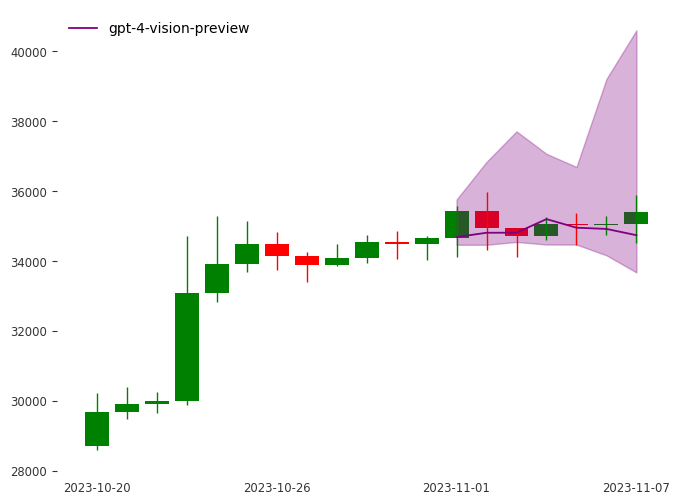

Input str :  -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['98, 17, 76, 147, -38, 69, 190', '-36, 203, 215, 109, -32, -19, 49', '520, -104, -3, 170, 360, 89, 35', '198, 484, 228, 172, 1199, 322, 221', '89, -40, -17, 60, 155, 74, 63', '187, 712, 98, 62, 225, 545, 168', '253, -58, 186, -39, 74, 158, 29', '1312, 581, 398, 141, 118, 215, 288', '137, 217, 82, 142, -63, -91, 72', '39, -26, -99, 18, 105, -32, -29']
int list return
[[98, 17, 76, 147, -38, 69, 190], [-36, 203, 215, 109, -32, -19, 49], [520, -104, -3, 170, 360, 89, 35], [198, 484, 228, 172, 1199, 322, 221], [89, -40, -17, 60, 155, 74, 63], [187, 712, 98, 62, 225, 545, 168], [253, -58, 186, -39, 74, 158, 29], [1312, 581, 398, 141, 118, 215, 288], [137, 217, 82, 142, -63, -91, 72], [39, -26, -99, 18, 105, -32, -29]]
serialized list :  [[34980.217985186646, 35039.68435576146, 35305.985956865254, 35824.98395043117, 35688.84901141953, 35935.102069

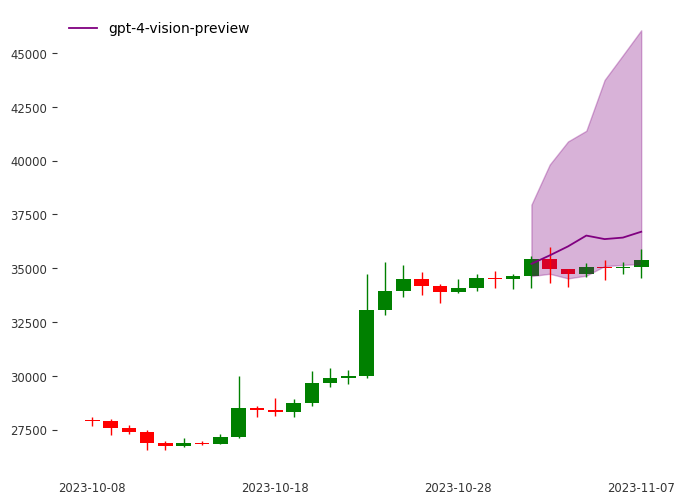

Input str :  115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['8, -53, -9, 223, 612, -26, 132', '-670, 36, -14, 72, 145, 74, 23', '-174, -324, 82, 665, 211, -94, -89', '-32, 2, 214, -69, 13, 197, 87', '-128, -150, -19, 324, 601, 242, 393', '-40, -79, 84, 322, -52, 19, 120', '-250, -63, -71, 314, 364, 28, -95', '150, 602, 88, -19, -122, 90, 145', '-172, -88, -23, 204, 1039, 145, 72', '-246, -123, 83, 209, -214, 190, 1038']
int list return
[[8, -53, -9, 223, 612, -26, 132], [-670, 36, -14, 72, 145, 74, 23], [-174, -324, 82, 665, 211, -94, -89], [-32, 2, 214, -69, 13, 197, 87], [-128, -150, -19, 324, 601, 242, 393], [-40, -79, 84, 322, -52, 19, 120], [-250, -63, -71, 314, 364, 28, -95], [150, 602, 88, -19, -122, 90, 145], [-172, -88, -23, 204, 1039, 145, 72], [-246, -123, 83, 209, -214, 190, 1

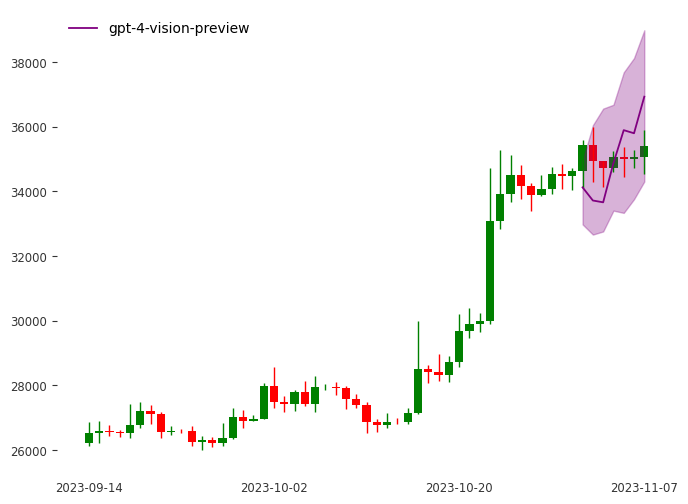

Input str :  31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-122, -11, -29, 255, 77, 28, 1109', '-80, -53, 13, -52, 131, 383, 315', '-157, -178, 56, 115, -12, -15, 731', '-192, -96, 7, -26, 27, -111, -295', '210, -120, -89, 847, -832, 44, 3', '-134, -32, 33, -77, -21, 158, 352', '-166, -24, 15, -147, 125, -140, -107', '39, -391, -32, 67, -70, -40, 11', '-31, -46, -58, 173, -106, -4, -22', '-24, -26, 18, -42, -81, -364, -41']
int list return
[[-122, -11, -29, 255, 77, 28, 1109], [-80, -53, 13, -52, 131, 383, 315], [-157, -178, 56, 115, -12, -15, 731], [-192, -96,

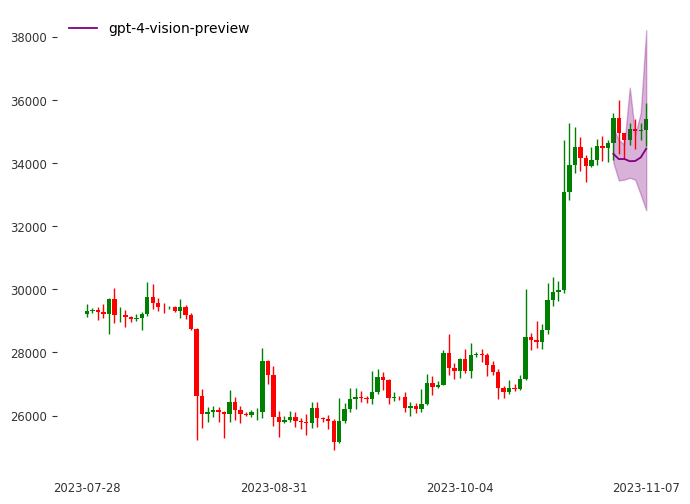

Input str :  -81, -29, 287, 41, 372, -55, -28, 1, -399, 214, 124, -65, 232, -222, -145, -268, -15, -11, -228, -64, -8, 53, 91, -47, 137, -213, 22, 83, -131, 38, 138, -327, 55, 88, 56, 451, -117, -15, -175, -144, 158, -64, 17, -511, 584, -327, 61, -8, -240, 33, -8, 11, -311, 187, 292, 65, -67, 192, 545, 596, -37, 269, -52, -21, -64, 140, -200, 123, 8, 37, 10, 176, -125, -85, -199, 150, -20, -41, 83, 69, -79, 354, -363, -7, -19, -31, -92, 17, -37, 34, -36, 97, -302, 18, 42, -44, 31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-101, -22, 114, 289, -61, -218, -7', '-

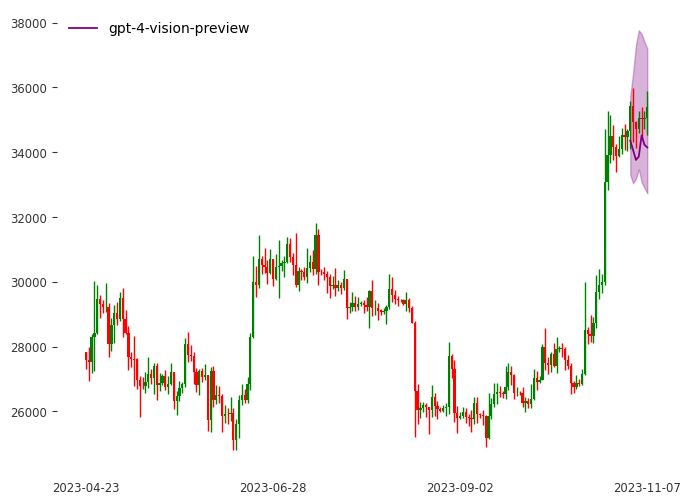

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_return_bitcoin.pkl
pickle/dic_error_return_bitcoin_median.pkl


In [2]:
data = bitcoin_data( mode = "return")
make_prediction(data)

In [3]:
all_return_dic = make_dic_MAE_MSE(path1="pickle/dic_error_return_bitcoin.pkl", path2 = "pickle/dic_error_return_bitcoin_median.pkl")

dic_error :
{'input_length': {6: {'Mae': [[421.1287040282259, 651.0806758978288, 957.2617066359162, 918.1266021183837, 1479.1681680838738, 2201.5981322339285, 2074.9345777653143], [393.4161130318389, 689.7702241878942, 607.6600636834119, 145.15349683573731, 931.1138433000742, 1807.5417603445094, 867.6986712610014], [396.88018690638273, 518.6220642844128, 518.0746443551761, 53.36539542411629, 1201.076719208737, 226.5553076724682, 1466.997122501045], [1401.4616105253372, 1022.8311802056196, 289.7338313167638, 274.1810628711537, 641.538769412422, 691.6812820113919, 272.5846002451581], [393.4161130318389, 546.1524926082275, 305.5832842574964, 54.20979323179927, 480.07331286498084, 479.0602219136417, 494.64652922270034], [559.6916590101537, 433.4786401351157, 661.3343680567777, 538.2838423289431, 844.7222674695076, 1367.5593240688904, 966.3485096478544], [383.02389140819287, 851.0093531599923, 2406.8066566868874, 4228.909209020741, 7622.764168043635, 12590.976216528448, 19630.34660034939], 

In [4]:
display_tab(all_return_dic)

Global MAE/MSE
Mean error with 3 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   697.357  725699
            12   664.706       1.05537e+06
            24  1461.79        5.81578e+06
            48  1312.46        2.28174e+06
            96   846.874  904773
           192  1325.63        2.54902e+06
Mean error with 5 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6  1092.22        3.1041e+06
            12   667.368  970017
            24  1918.12        9.29961e+06
            48  1250.73        2.23152e+06
            96   915.628       1.08414e+06
           192  1325.11        2.80362e+06
Mean error with 7 days forecasting
  input_length       Mae          Mse
--------------  --------  -----------
             6  1911.71   1.46381e+07
            12   875.337  2.23473e+06
            24  2399.42   1.43139e+07
            48  1372.98   2.77534

In [1]:
from datetime import datetime, timedelta
import pickle
import copy

from package.query import *
from package.plot import *
from package.data_mgt import *
from package.seriealize import *
from package.dic_mgt import *
from package.data import *


data = dart_data()
make_prediction(data)

Not enough data with the current preset. Starting date is set as 1949-01-01, ending date is set as 1958-12-01, input_length is set as [6, 12, 24, 48, 96, 192] and the predict interval is set as [3, 5, 7]. So with these preset you need to have at least 119 DataPoints available. The input_length has been troncatenated to [6, 12, 24, 48, 96]. Let's remember that for the current DataSet AirPassengersDataset the first dataPoint is 1949-01-01 and the last DataPoint is 1960-12-01


TypeError: get_data_darts() takes 3 positional arguments but 4 were given

In [2]:
with open('pickle/dic_error_APD.pkl', 'rb') as fichier:
    dict_error_APD = pickle.load(fichier)

with open('pickle/dic_error_APD_median.pkl', 'rb') as fichier:
    dict_error_APD_median = pickle.load(fichier)

list_of_length = [6, 12, 24, 48, 96, 130]

get_specific_dic(list_of_length)

dic_error_3_APD = get_specific_dic(list_of_length)
dic_error_5_APD = get_specific_dic(list_of_length)
dic_error_7_APD = get_specific_dic(list_of_length)

dic_error_3_APD_median = get_specific_dic(list_of_length)
dic_error_5_APD_median = get_specific_dic(list_of_length)
dic_error_7_APD_median = get_specific_dic(list_of_length)

print(dict_error_APD)
dic_mgt(dict_error_APD, dic_error_3_APD, dic_error_5_APD, dic_error_7_APD)
dic_mgt(dict_error_APD_median, dic_error_3_APD_median, dic_error_5_APD_median, dic_error_7_APD_median)

print(dic_error_3_APD)

{'input_length': {6: {'Mae': [[16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 14.0, 12.0, 26.0, 33.0, 33.0, 43.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 12.0, 14.0, 36.0, 47.0, 47.0, 57.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 12.0, 18.0, 34.0, 43.0, 45.0, 57.0], [6.0, 12.0, 12.0, 26.0, 33.0, 33.0, 43.0], [6.0, 14.0, 12.0, 26.0, 33.0, 33.0, 43.0]], 'Mse': [[256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 196.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 144.0, 196.0, 1296.0, 2209.0, 2209.0, 3249.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 144.0, 324.0, 1156.0, 1849.0, 2025.0, 3249.0], [36.0, 144.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0], [36.0, 196.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0]]}, 12: {'Mae': [[17.

In [3]:
print("Global MAE/MSE")
table_display(dic_error_3_APD)
table_display(dic_error_5_APD)
table_display(dic_error_7_APD)

print("##############################")
print("Median MAE/MSE")
table_display(dic_error_3_APD_median)
table_display(dic_error_5_APD_median)
table_display(dic_error_7_APD_median)

Global MAE/MSE
  input_length       Mae       Mse
--------------  --------  --------
             6  12.4      204.533
            12  12.9333   265.067
            24   8.46667  125
            48  12.2333   215.767
            96   7.33333   83.7333
           130  11.1333   168.467
  input_length    Mae     Mse
--------------  -----  ------
             6  18.08  437.32
            12  14.44  347.88
            24  10.16  168.48
            48  14.38  286.62
            96   7.78   90.58
           130  15.4   391.48
  input_length      Mae      Mse
--------------  -------  -------
             6  22.4     667.171
            12  17.4     519.286
            24  11.7     289.186
            48  14.7857  382.014
            96  13.0857  871.543
           130  15.7143  391.914
##############################
Median MAE/MSE
  input_length      Mae       Mse
--------------  -------  --------
             6  12.3333  177
            12  13.5     255.75
            24   6        53.1667
 

In [8]:
import darts
import pandas as pd

# Charger le jeu de données AirPassenger
air_passenger_ds = darts.datasets.AirPassengersDataset().load()

first_date = air_passenger_ds.time_index[0]
last_date = air_passenger_ds.time_index[-1]

print("Première date possible :", first_date)
print("Dernière date possible :", last_date)

Première date possible : 1949-01-01 00:00:00
Dernière date possible : 1960-12-01 00:00:00
